<a href="https://colab.research.google.com/github/Jeanritah/Jeanritah.github.io/blob/main/Deep%20-Learning%20project%20Infix_to_postifx_notation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [4]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [5]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

2552
infix :  ( ( ( c * e ) * d ) + ( b * e ) )
posfix notation:  c e * d * b e * +
teacher forcing :  SOS c e * d * b e * +


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

In [8]:
# Model Hyperparameters (you can tune these if needed)
EMBEDDING_DIM = 64  # Dimension of the embedding space for each token
LSTM_UNITS = 128    # Number of LSTM units (determines the 'capacity' of the RNN)

In [9]:
# -------------------- Encoder --------------------
def create_encoder(vocab_size, embedding_dim, lstm_units, max_len):
    # Input layer: Takes sequences of token IDs
    encoder_inputs = layers.Input(shape=(max_len,), name="encoder_input")

    # Embedding layer: Converts token IDs into dense vectors
    encoder_embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True # Important: tells Keras to ignore PAD_ID (0) in calculations
    )(encoder_inputs)

    # Encoder LSTM layer: Processes the input sequence
    # `return_state=True` is crucial to get the final hidden and cell states
    encoder_lstm = layers.LSTM(
        lstm_units,
        return_state=True,
        name="encoder_lstm"
    )
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

    # The encoder outputs (state_h, state_c) are the context vectors
    # We discard `encoder_outputs` because we only need the states for the decoder
    encoder_states = [state_h, state_c]

    return encoder_inputs, encoder_states

In [10]:
# -------------------- Decoder --------------------
def create_decoder(vocab_size, embedding_dim, lstm_units, max_len):
    # Input layer: Takes the shifted-right target sequence (for teacher forcing)
    decoder_inputs = layers.Input(shape=(max_len,), name="decoder_input")

    # Embedding layer: Similar to encoder, for output tokens
    decoder_embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True # Also important for padding in the output sequence
    )(decoder_inputs)

    # Decoder LSTM layer: Processes the target sequence given initial states
    # `return_sequences=True` because we need an output prediction at each time step
    # `return_state=True` because we will need the final states for inference (prediction)
    decoder_lstm = layers.LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True,
        name="decoder_lstm"
    )
    # The initial_state is set to the encoder's final states
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states_placeholder) # Use a placeholder here

    # Dense layer: Maps LSTM output to a probability distribution over the vocabulary
    decoder_dense = layers.Dense(vocab_size, activation='softmax', name="decoder_output")
    decoder_outputs = decoder_dense(decoder_outputs)

    return decoder_inputs, decoder_outputs, decoder_lstm, decoder_dense # Return dense layer for inference

In [11]:
# -------------------- Build the Full Model --------------------
# Create encoder parts
encoder_inputs, encoder_states = create_encoder(VOCAB_SIZE, EMBEDDING_DIM, LSTM_UNITS, MAX_LEN)

# Create decoder parts
# We need to pass the encoder states to the decoder's LSTM as initial state
decoder_inputs_placeholder = layers.Input(shape=(MAX_LEN,), name="decoder_input_for_training") # Use a clear name for training input
decoder_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True)
decoder_lstm_layer = layers.LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
decoder_dense_layer = layers.Dense(VOCAB_SIZE, activation='softmax')

decoder_embedding_output = decoder_embedding_layer(decoder_inputs_placeholder)
decoder_outputs, _, _ = decoder_lstm_layer(decoder_embedding_output, initial_state=encoder_states)
decoder_outputs = decoder_dense_layer(decoder_outputs)


# Define the training model
model = models.Model(inputs=[encoder_inputs, decoder_inputs_placeholder], outputs=decoder_outputs)

# Compile the model
# We use sparse_categorical_crossentropy because our target labels are integer IDs
# We use 'adam' optimizer which is a good general-purpose optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to check architecture and parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_for_… │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 64)    │        960 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 30, 64)    │        960 │ decoder_input_fo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │     98,816 │ embedding[0][0],  │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 30, 128), │     98,816 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 15)    │      1,935 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,487 (787.06 KB)

 Trainable params: 201,487 (787.06 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# -------------------- Autoregressive Decoding for Inference --------------------

# 1. Create the Encoder model (takes encoder_inputs, outputs encoder_states)
encoder_model = models.Model(encoder_inputs, encoder_states)

# 2. Create the Decoder model for inference
# The decoder's input state placeholder
decoder_state_input_h = layers.Input(shape=(LSTM_UNITS,), name='decoder_h_input')
decoder_state_input_c = layers.Input(shape=(LSTM_UNITS,), name='decoder_c_input')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse the decoder's embedding layer (created in the training model setup)
_decoder_embedding_output = decoder_embedding_layer(decoder_inputs_placeholder) # Use the same placeholder for input

# Reuse the decoder's LSTM layer and pass the new states
decoder_outputs_inference, state_h_inference, state_c_inference = decoder_lstm_layer(
    _decoder_embedding_output, initial_state=decoder_states_inputs
)
decoder_states_inference = [state_h_inference, state_c_inference]

# Reuse the decoder's dense layer
decoder_outputs_inference = decoder_dense_layer(decoder_outputs_inference)

# Define the decoder model for inference
decoder_model = models.Model(
    [decoder_inputs_placeholder] + decoder_states_inputs,
    [decoder_outputs_inference] + decoder_states_inference
)


def autoregressive_decode(model, encoder_input):
    """
    Performs autoregressive decoding (inference) using the trained encoder-decoder model.
    """
    # Reshape encoder_input to (1, MAX_LEN) for single prediction
    encoder_input = np.expand_dims(encoder_input, axis=0)

    # Get the initial decoder states from the encoder
    states_value = encoder_model.predict(encoder_input, verbose=0)

    # Initialize decoder input with the SOS token
    target_seq = np.zeros((1, MAX_LEN))
    target_seq[0, 0] = SOS_ID

    # Store the generated sequence
    decoded_sequence = np.zeros((1, MAX_LEN), dtype='int32')
    decoded_sequence[0, 0] = SOS_ID # Start with SOS in the output

    # Sampling loop for a batch of 1 (single input)
    for i in range(1, MAX_LEN):
        # Predict the next token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample a token (take the one with highest probability)
        # `output_tokens` shape is (1, MAX_LEN, VOCAB_SIZE), we need the prediction for the current step (i-1)
        # and then the argmax over the vocab dimension
        sampled_token_index = np.argmax(output_tokens[0, i-1, :]) # Use i-1 because target_seq is one step ahead

        # Store the sampled token
        decoded_sequence[0, i] = sampled_token_index

        # Exit condition: EOS or max length reached
        if sampled_token_index == EOS_ID:
            break

        # Update the target sequence for the next timestep (teacher-forcing style for *this single prediction*)
        # This means the token predicted at current step (i-1) becomes input for next step (i)
        target_seq[0, i] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sequence[0] # Return the 1D array of decoded IDs

Starting model training...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.6724 - loss: 1.9400 - val_accuracy: 0.8818 - val_loss: 1.1634
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8997 - loss: 1.0202 - val_accuracy: 0.9251 - val_loss: 0.7181
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9453 - loss: 0.5927 - val_accuracy: 0.9584 - val_loss: 0.4427
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9647 - loss: 0.3881 - val_accuracy: 0.9713 - val_loss: 0.3047
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9779 - loss: 0.2567 - val_accuracy: 0.9842 - val_loss: 0.2023
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9862 - loss: 0.1858 - val_accuracy: 0.9896 - val_loss: 0.1445
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9898 - loss: 0.1396 - val_accuracy: 0.9905 - val_loss: 0.1240
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step -

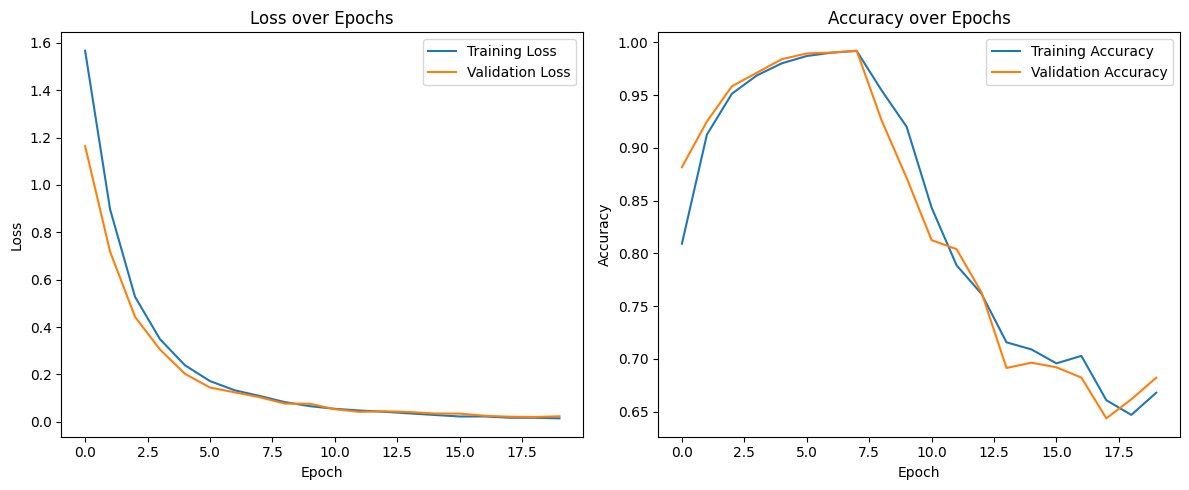

In [14]:
# -------------------- Model Training --------------------

# Training parameters
BATCH_SIZE = 64
EPOCHS = 20 # You might need to adjust this based on performance

print("Starting model training...")

# Train the model
# We pass X_train (encoder input) and decoder_input_train (decoder input for teacher forcing) as inputs
# Y_train is the target output (what the model should predict)
history = model.fit(
    [X_train, decoder_input_train],
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_val, decoder_input_val], Y_val)
)

print("Model training complete.")

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

In [15]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 0.30445066045066044 std= 0.07684609099974493


Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.